# Experience Analytics


In [1]:
import pandas as pd
import numpy as np
import matplotlib
from sqlalchemy import create_engine
from urllib.parse import quote

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

In [12]:
username = 'postgres'
password = 'nati@postgres'
hostname = 'localhost'
port = '5432'
database_name = 'TellCo'

# Escape the special characters in the password
escaped_password = quote(password, safe='')

# Create the database engine
engine = create_engine(f'postgresql://{username}:{escaped_password}@{hostname}:{port}/{database_name}')

# Establish a connection
with engine.connect() as connection:
    # Query the data and load it into a pandas DataFrame
    query = """
        SELECT *
        FROM xdr_data
    """
    df = pd.read_sql(query, connection)

df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


### Aggregate, per customer, the following information

- Average TCP retransmission
- Average RTT
- Handset type
- Average throughput


First we need to treat missing & outliers by replacing by the mean or the mode of the corresponding variable.

In [18]:
def detect_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return outliers

First let's see which field have outlier and missing values.

In [19]:
# Create an empty list to store the results
result_data = []

# Iterate over the columns and identify outliers and missing values
for column in df.columns:
    # Fetch data from the DataFrame for the specified column
    data = df[column]

    # Check if the column is numeric
    if np.issubdtype(data.dtype, np.number):
        # Identify outliers
        outliers = detect_outliers(data)

        # Count the number of outliers
        num_outliers = np.count_nonzero(outliers)
    else:
        num_outliers = 0

    # Count the number of missing values
    num_missing = data.isnull().sum()

    # Append the results to the result list
    result_data.append([column, num_outliers, num_missing])

# Create the result DataFrame
result_df = pd.DataFrame(result_data, columns=['Field', 'Number of outliers', 'Number of missing values'])

# Replace NaN values in the result DataFrame with zero
result_df = result_df.fillna(0)

# Print the result DataFrame
result_df

,Field,Number of outliers,Number of missing values
0,Bearer Id,0,0
1,Start,0,0
2,Start ms,0,0
3,End,0,0
4,End ms,0,0
5,Dur. (ms),6020,0
6,IMSI,13247,0
7,MSISDN/Number,24742,0
8,IMEI,0,0
9,Last Location Name,0,0


Now, let's substitue the outliers and the missing values in each column.

In [20]:
# Iterate over the columns and identify outliers and missing values
for column in df.columns:
    # Fetch data from the DataFrame for the specified column
    data = df[column]

    # Check if the column is numeric
    if np.issubdtype(data.dtype, np.number):
        # Identify outliers
        outliers = detect_outliers(data)

        # Calculate the mean of the column
        column_mean = data.mean()

        # Replace outliers and missing values with the mean
        df.loc[outliers, column] = column_mean
        df.loc[data.isnull(), column] = column_mean
    else:
        # Calculate the mode of the column
        column_mode = data.mode().values[0]
        
        # Replace missing values with the mode
        df.loc[data.isnull(), column] = column_mode

In [21]:
# Create an empty list to store the results
result_data = []

# Iterate over the columns and identify outliers and missing values
for column in df.columns:
    # Fetch data from the DataFrame for the specified column
    data = df[column]

    # Check if the column is numeric
    if np.issubdtype(data.dtype, np.number):
        # Identify outliers
        outliers = identify_outliers(data)

        # Count the number of outliers
        num_outliers = np.count_nonzero(outliers)
    else:
        num_outliers = 0

    # Count the number of missing values
    num_missing = data.isnull().sum()

    # Append the results to the result list
    result_data.append([column, num_outliers, num_missing])

# Create the result DataFrame
result_df = pd.DataFrame(result_data, columns=['Field', 'Number of outliers', 'Number of missing values'])

# Replace NaN values in the result DataFrame with zero
result_df = result_df.fillna(0)

# Print the result DataFrame
result_df

,Field,Number of outliers,Number of missing values
0,Bearer Id,0,0
1,Start,0,0
2,Start ms,0,0
3,End,0,0
4,End ms,0,0
5,Dur. (ms),0,0
6,IMSI,0,0
7,MSISDN/Number,0,0
8,IMEI,0,0
9,Last Location Name,0,0


Now, let's continue with aggregating

In [25]:
# Group by customer (MSISDN/Number)
grouped_df = df.groupby('MSISDN/Number')

# Define a custom aggregation function to get the most common handset type for each user
def most_common(series):
    return series.mode().iloc[0] if not series.mode().empty else None

# Aggregate the required information
aggregated_df = grouped_df.agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Handset Type': most_common,
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

aggregated_df.head()

,MSISDN/Number,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Handset Type,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,3.360171e+10,2.080991e+07,759658.664811,110.000000,5.000000,Apple iPhone Se (A1723),23.000000,47.0
1,3.360171e+10,5.751940e+05,44040.000000,145.000000,7.000000,Apple iPhone 6 (A1586),7677.000000,2115.0
2,3.360171e+10,1.798137e+07,441902.832406,104.397853,18.831441,Samsung Galaxy S8 Plus (Sm-G955F),6671.522963,676.5
3,3.360171e+10,2.080991e+07,759658.664811,29.000000,5.000000,Apple iPhone 7 Plus (A1784),63.000000,54.0
4,3.360172e+10,2.080991e+07,759658.664811,109.795706,17.662883,Samsung Galaxy S8 (Sm-G950F),12.000000,64.0


Now, let's Compute & list 10 of the top, bottom and most frequent:
- TCP values in the dataset. 
- RTT values in the dataset.
- Throughput values in the dataset.

In [63]:
# Define the columns of interest
tcp_columns = ['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']
rtt_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)']
throughput_columns = ['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

# Create DataFrames for each metric
def create_metric_df(columns):
    values = pd.concat([df[column] for column in columns])
    top_10 = values.nlargest(10).tolist()
    bottom_10 = values.nsmallest(10).tolist()
    most_frequent = values.value_counts().head(10).index.tolist()
    
    return pd.DataFrame({
        'Top 10 Values': top_10,
        'Bottom 10 Values': bottom_10,
        'Most Frequent Values': most_frequent
    })

# Create DataFrames for each metric
tcp_values_df = create_metric_df(tcp_columns)
rtt_values_df = create_metric_df(rtt_columns)
throughput_values_df = create_metric_df(throughput_columns)


In [64]:
# Display the DataFrames
print("TCP Values:")
tcp_values_df

TCP Values:


,Top 10 Values,Bottom 10 Values,Most Frequent Values
0,50021024.0,1.0,7.596587e+05
1,49991791.0,1.0,2.080991e+07
2,49986834.0,1.0,1.330000e+03
3,49986038.0,1.0,1.557372e+07
4,49969605.0,1.0,5.985222e+05
5,49921268.0,1.0,2.660000e+03
6,49833677.0,1.0,1.318000e+03
7,49779123.0,1.0,3.990000e+03
8,49777538.0,1.0,1.294000e+03
9,49663906.0,1.0,5.320000e+03


In [65]:
print("\nRTT Values:")
rtt_values_df



RTT Values:


,Top 10 Values,Bottom 10 Values,Most Frequent Values
0,221.0,0.0,109.795706
1,221.0,0.0,17.662883
2,221.0,0.0,5.000000
3,221.0,0.0,2.000000
4,221.0,0.0,1.000000
5,221.0,0.0,4.000000
6,221.0,0.0,13.921386
7,221.0,0.0,3.000000
8,221.0,0.0,6.000000
9,221.0,0.0,86.411792


In [66]:
print("\nThroughput Values:")
throughput_values_df


Throughput Values:


,Top 10 Values,Bottom 10 Values,Most Frequent Values
0,42183.0,0.0,1151.190428
1,42181.0,0.0,11315.319458
2,42180.0,0.0,40.000000
3,42179.0,0.0,47.000000
4,42178.0,0.0,54.000000
5,42175.0,0.0,44.000000
6,42175.0,0.0,23.000000
7,42175.0,0.0,53.000000
8,42173.0,0.0,43.000000
9,42172.0,0.0,48.000000


### Average throughput per handset type

In [68]:
# Distribution of Average Throughput per Handset Type
avg_throughput_by_handset = df.groupby('Handset Type').agg({
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

# Display the distribution of average throughput per handset type
print("Distribution of Average Throughput per Handset Type:")
avg_throughput_by_handset

Distribution of Average Throughput per Handset Type:


,Handset Type,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,A-Link Telecom I. Cubot A5,23184.000000,326.000000
1,A-Link Telecom I. Cubot Note Plus,6527.000000,172.000000
2,A-Link Telecom I. Cubot Note S,8515.000000,422.000000
3,A-Link Telecom I. Cubot Nova,11315.319458,550.000000
4,A-Link Telecom I. Cubot Power,11315.319458,342.000000
...,...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,44.500000,13.500000
1392,Zyxel Communicat. Lte7460,39741.000000,1770.428647
1393,Zyxel Communicat. Sbg3600,11315.319458,1151.190428
1394,Zyxel Communicat. Zyxel Wah7706,1263.000000,910.000000


### Average TCP retransmission view per handset type

In [69]:
# Average TCP Retransmission per Handset Type
avg_tcp_retransmission_by_handset = df.groupby('Handset Type').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean'
}).reset_index()

# Display the average TCP retransmission per handset type
print("\nAverage TCP Retransmission per Handset Type:")
avg_tcp_retransmission_by_handset


Average TCP Retransmission per Handset Type:


,Handset Type,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,A-Link Telecom I. Cubot A5,2.080991e+07,759658.664811
1,A-Link Telecom I. Cubot Note Plus,6.023490e+05,13864.000000
2,A-Link Telecom I. Cubot Note S,4.134448e+07,67252.000000
3,A-Link Telecom I. Cubot Nova,1.358400e+05,1330.000000
4,A-Link Telecom I. Cubot Power,7.799000e+03,242.000000
...,...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,1.040629e+07,759658.664811
1392,Zyxel Communicat. Lte7460,2.384303e+07,598522.237871
1393,Zyxel Communicat. Sbg3600,1.557372e+07,598522.237871
1394,Zyxel Communicat. Zyxel Wah7706,1.160000e+02,759658.664811


### k-means clustering

 We will now divide the users into three clusters using k-means clustering (where k = 3) to segment users into groups of experiences. We will use the three user experience metrics we have been using so far i.e (TCP retransmission, Round Trip Time (RTT), and Throughput).

In [72]:
# Select relevant columns
user_experience_metrics = df[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']]

# Standardize the data
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(user_experience_metrics)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_metrics)

# Display the cluster assignments
print("Cluster Assignments:")
df[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)', 'Cluster']].head()


c:\Users\User\miniconda3\envs\telecom_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Assignments:


,TCP DL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg Bearer TP DL (kbps),Cluster
0,2.080991e+07,42.000000,23.0,1
1,2.080991e+07,65.000000,16.0,1
2,2.080991e+07,109.795706,6.0,2
3,2.080991e+07,109.795706,44.0,2
4,2.080991e+07,109.795706,6.0,2


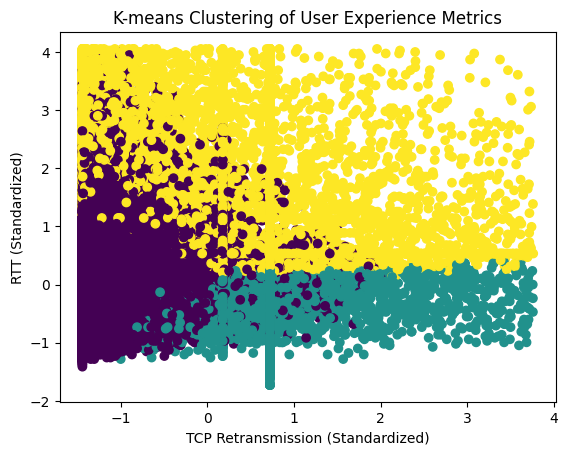

In [73]:
# Visualize the clusters
plt.scatter(scaled_metrics[:, 0], scaled_metrics[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('K-means Clustering of User Experience Metrics')
plt.xlabel('TCP Retransmission (Standardized)')
plt.ylabel('RTT (Standardized)')
plt.show()